Now I will load the exact same dataset (CIFAR-10) from tensorflow and carry out the same pre-processing steps as I did previously.

Training set shape: (50000, 32, 32, 3) images
Test set shape: (10000, 32, 32, 3) images
Image dimensions: 32x32 pixels


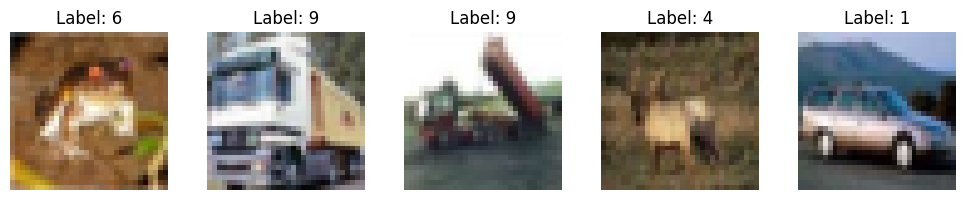

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Training set shape: {x_train.shape} images")
print(f"Test set shape: {x_test.shape} images")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])
    ax.set_title(f"Label: {y_train[i][0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, ColorJitter
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

test_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

x_train_transformed = torch.stack([
    train_transform(Image.fromarray(img)) for img in x_train
])
x_test_transformed = torch.stack([
    test_transform(Image.fromarray(img)) for img in x_test
])

y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()

train_dataset = TensorDataset(x_train_transformed, y_train_tensor)
test_dataset = TensorDataset(x_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
]

def train_model_epoch(model, optimizer, epochs):
    for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            all_labels = []
            all_predictions = []

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            precision = precision_score(all_labels, all_predictions, average='weighted')
            recall = recall_score(all_labels, all_predictions, average='weighted')
            f1 = f1_score(all_labels, all_predictions, average='weighted')

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

            if epoch == 9:
                cm = confusion_matrix(all_labels, all_predictions, labels=range(10))

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels")
                plt.title("Confusion Matrix")
                plt.show()

Everything is now set up to expand and test with larger neural networks. I will record the training results after each improvement to monitor convergence and metrics and then carry out a final evaluation on the test set.

The last model had 2 convolutional layers, 1 pooling layer and 2 fully connected layers. I will firstly add a dropout layer with 0.3 dropout.

Epoch [1/10], Loss: 1.4871, Accuracy: 49.47%
Precision: 0.4895, Recall: 0.4947, F1 Score: 0.4905
Epoch [2/10], Loss: 0.9926, Accuracy: 65.17%
Precision: 0.6487, Recall: 0.6517, F1 Score: 0.6499
Epoch [3/10], Loss: 0.7969, Accuracy: 71.97%
Precision: 0.7178, Recall: 0.7197, F1 Score: 0.7186
Epoch [4/10], Loss: 0.6334, Accuracy: 77.83%
Precision: 0.7770, Recall: 0.7783, F1 Score: 0.7775
Epoch [5/10], Loss: 0.4943, Accuracy: 82.78%
Precision: 0.8271, Recall: 0.8278, F1 Score: 0.8274
Epoch [6/10], Loss: 0.3801, Accuracy: 86.77%
Precision: 0.8674, Recall: 0.8677, F1 Score: 0.8676
Epoch [7/10], Loss: 0.3008, Accuracy: 89.65%
Precision: 0.8963, Recall: 0.8965, F1 Score: 0.8964
Epoch [8/10], Loss: 0.2510, Accuracy: 91.26%
Precision: 0.9125, Recall: 0.9126, F1 Score: 0.9125
Epoch [9/10], Loss: 0.2194, Accuracy: 92.38%
Precision: 0.9237, Recall: 0.9238, F1 Score: 0.9238
Epoch [10/10], Loss: 0.1959, Accuracy: 93.23%
Precision: 0.9322, Recall: 0.9323, F1 Score: 0.9322


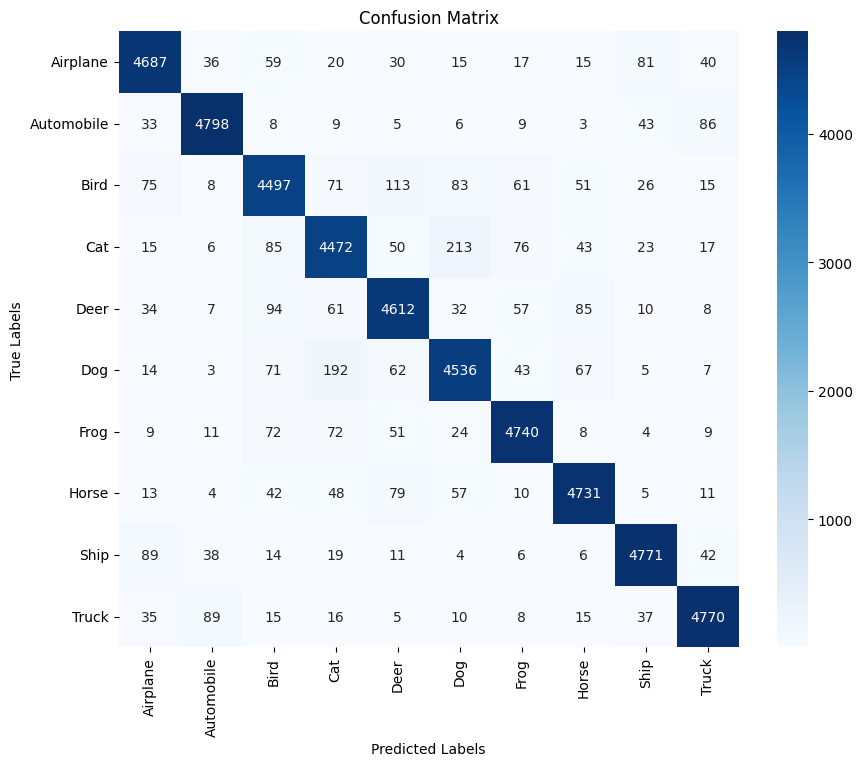

In [ ]:
class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

learning_rate = 0.001
num_epochs = 10

model_optimized = CNN_Optimized()
model_optimized.to(device)

model_optimized_optimizer = torch.optim.RMSprop(
    model_optimized.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized, model_optimized_optimizer, num_epochs)


Adding dropout slightly reduced the accuracy to 93%, which is expected as it disables random neurons making the model less powerful in representing patterns, however greatly reduces over-reliance on specific neurons which in-turn improves generalisation. Now I will add 1 convolutional layer and 1 more pooling layer:

Epoch [1/10], Loss: 1.5351, Accuracy: 47.12%
Precision: 0.4665, Recall: 0.4712, F1 Score: 0.4671
Epoch [2/10], Loss: 0.9994, Accuracy: 64.70%
Precision: 0.6439, Recall: 0.6470, F1 Score: 0.6452
Epoch [3/10], Loss: 0.7761, Accuracy: 73.05%
Precision: 0.7287, Recall: 0.7305, F1 Score: 0.7295
Epoch [4/10], Loss: 0.6339, Accuracy: 77.73%
Precision: 0.7761, Recall: 0.7773, F1 Score: 0.7767
Epoch [5/10], Loss: 0.5208, Accuracy: 81.87%
Precision: 0.8181, Recall: 0.8187, F1 Score: 0.8184
Epoch [6/10], Loss: 0.4159, Accuracy: 85.39%
Precision: 0.8534, Recall: 0.8539, F1 Score: 0.8536
Epoch [7/10], Loss: 0.3313, Accuracy: 88.21%
Precision: 0.8818, Recall: 0.8821, F1 Score: 0.8819
Epoch [8/10], Loss: 0.2749, Accuracy: 90.32%
Precision: 0.9030, Recall: 0.9032, F1 Score: 0.9031
Epoch [9/10], Loss: 0.2303, Accuracy: 91.86%
Precision: 0.9185, Recall: 0.9186, F1 Score: 0.9185
Epoch [10/10], Loss: 0.2032, Accuracy: 92.81%
Precision: 0.9280, Recall: 0.9281, F1 Score: 0.9280


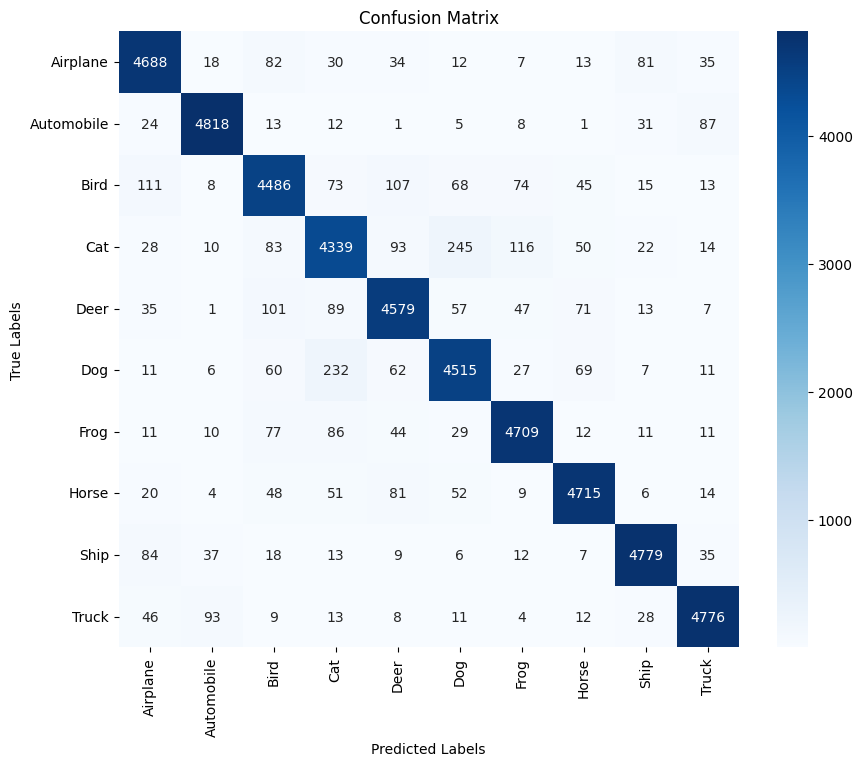

In [ ]:
class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_optimized_2 = CNN_Optimized()
model_optimized_2.to(device)

model_optimized_optimizer_2 = torch.optim.RMSprop(
    model_optimized_2.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_2, model_optimized_optimizer_2, num_epochs)


Now 1 more convolutional layer and 1 more fully connected layer:

Epoch [1/10], Loss: 1.7375, Accuracy: 38.51%
Precision: 0.3777, Recall: 0.3851, F1 Score: 0.3775
Epoch [2/10], Loss: 1.1131, Accuracy: 60.43%
Precision: 0.5996, Recall: 0.6043, F1 Score: 0.6016
Epoch [3/10], Loss: 0.8625, Accuracy: 69.43%
Precision: 0.6919, Recall: 0.6943, F1 Score: 0.6929
Epoch [4/10], Loss: 0.7093, Accuracy: 75.21%
Precision: 0.7507, Recall: 0.7521, F1 Score: 0.7513
Epoch [5/10], Loss: 0.5955, Accuracy: 79.20%
Precision: 0.7911, Recall: 0.7920, F1 Score: 0.7915
Epoch [6/10], Loss: 0.5034, Accuracy: 82.23%
Precision: 0.8215, Recall: 0.8223, F1 Score: 0.8219
Epoch [7/10], Loss: 0.4189, Accuracy: 85.20%
Precision: 0.8515, Recall: 0.8520, F1 Score: 0.8517
Epoch [8/10], Loss: 0.3548, Accuracy: 87.53%
Precision: 0.8751, Recall: 0.8753, F1 Score: 0.8752
Epoch [9/10], Loss: 0.3055, Accuracy: 89.36%
Precision: 0.8934, Recall: 0.8936, F1 Score: 0.8935
Epoch [10/10], Loss: 0.2704, Accuracy: 90.68%
Precision: 0.9068, Recall: 0.9068, F1 Score: 0.9068


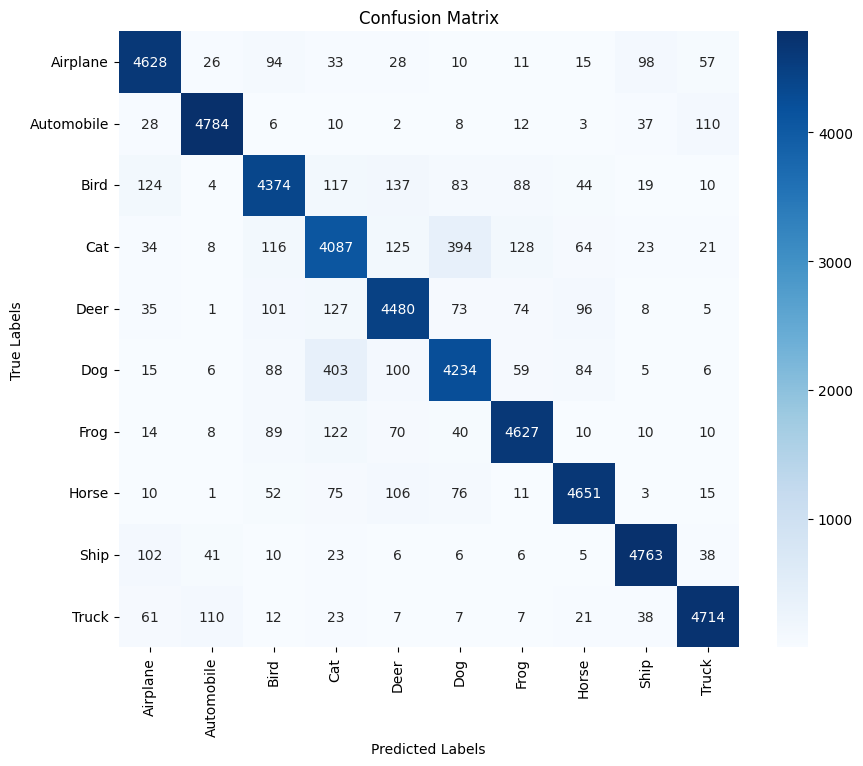

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_optimized_3 = CNN_Optimized()
model_optimized_3.to(device)

model_optimized_optimizer_3 = torch.optim.RMSprop(
    model_optimized_3.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_3, model_optimized_optimizer_3, num_epochs)


And 1 more convolutional layer with 1 pooling layer:

Epoch [1/10], Loss: 2.2338, Accuracy: 36.58%
Precision: 0.3577, Recall: 0.3658, F1 Score: 0.3581
Epoch [2/10], Loss: 1.2291, Accuracy: 55.84%
Precision: 0.5529, Recall: 0.5584, F1 Score: 0.5550
Epoch [3/10], Loss: 0.9344, Accuracy: 67.27%
Precision: 0.6710, Recall: 0.6727, F1 Score: 0.6717
Epoch [4/10], Loss: 0.7538, Accuracy: 73.79%
Precision: 0.7366, Recall: 0.7379, F1 Score: 0.7371
Epoch [5/10], Loss: 0.6249, Accuracy: 78.31%
Precision: 0.7825, Recall: 0.7831, F1 Score: 0.7827
Epoch [6/10], Loss: 0.5291, Accuracy: 81.57%
Precision: 0.8153, Recall: 0.8157, F1 Score: 0.8155
Epoch [7/10], Loss: 0.4452, Accuracy: 84.40%
Precision: 0.8437, Recall: 0.8440, F1 Score: 0.8438
Epoch [8/10], Loss: 0.3811, Accuracy: 86.76%
Precision: 0.8673, Recall: 0.8676, F1 Score: 0.8674
Epoch [9/10], Loss: 0.3261, Accuracy: 88.53%
Precision: 0.8850, Recall: 0.8853, F1 Score: 0.8852
Epoch [10/10], Loss: 0.2836, Accuracy: 90.12%
Precision: 0.9010, Recall: 0.9012, F1 Score: 0.9011


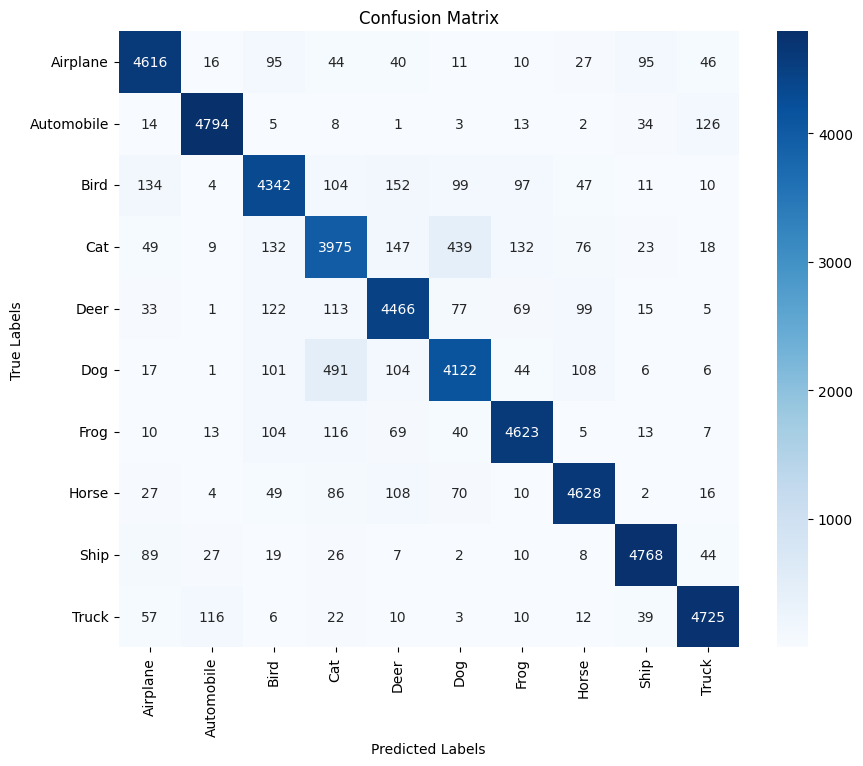

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_optimized_4 = CNN_Optimized()
model_optimized_4.to(device)

model_optimized_optimizer_4 = torch.optim.RMSprop(
    model_optimized_4.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_4, model_optimized_optimizer_4, num_epochs)

Now that i've expanded the model and made it more complex, I'll look at some other ways to tweak the model to make it better at generalizing.

I will first test out adding batch normalization to the model after each convolutional layer:

Epoch [1/10], Loss: 2.0823, Accuracy: 31.01%
Precision: 0.3046, Recall: 0.3101, F1 Score: 0.3039
Epoch [2/10], Loss: 1.2490, Accuracy: 54.21%
Precision: 0.5366, Recall: 0.5421, F1 Score: 0.5383
Epoch [3/10], Loss: 0.9610, Accuracy: 66.05%
Precision: 0.6577, Recall: 0.6605, F1 Score: 0.6588
Epoch [4/10], Loss: 0.7888, Accuracy: 72.39%
Precision: 0.7217, Recall: 0.7239, F1 Score: 0.7226
Epoch [5/10], Loss: 0.6778, Accuracy: 76.69%
Precision: 0.7653, Recall: 0.7669, F1 Score: 0.7660
Epoch [6/10], Loss: 0.5861, Accuracy: 80.06%
Precision: 0.7995, Recall: 0.8006, F1 Score: 0.7999
Epoch [7/10], Loss: 0.5147, Accuracy: 82.30%
Precision: 0.8223, Recall: 0.8230, F1 Score: 0.8225
Epoch [8/10], Loss: 0.4513, Accuracy: 84.62%
Precision: 0.8456, Recall: 0.8462, F1 Score: 0.8459
Epoch [9/10], Loss: 0.3942, Accuracy: 86.56%
Precision: 0.8653, Recall: 0.8656, F1 Score: 0.8654
Epoch [10/10], Loss: 0.3435, Accuracy: 88.33%
Precision: 0.8831, Recall: 0.8833, F1 Score: 0.8831


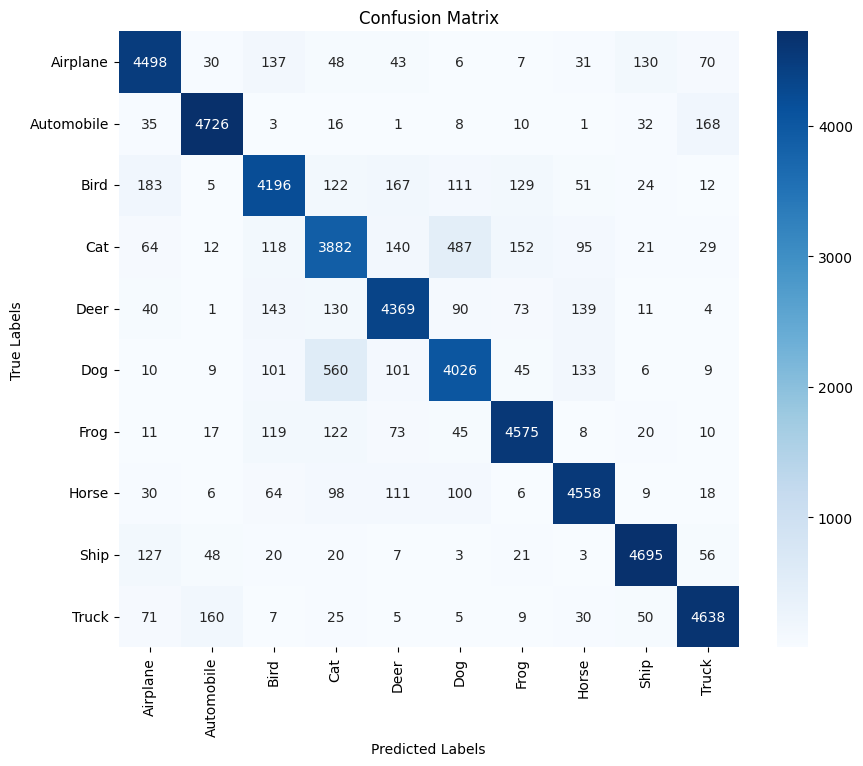

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_batchnorm = CNN_BatchNorm()
model_batchnorm.to(device)

model_batchnorm_optimizer = torch.optim.RMSprop(
    model_batchnorm.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_batchnorm, model_batchnorm_optimizer, num_epochs)

Adding Batch Normalisation didn't affect the accuracy of the model and doesn't make generalization better. I will try another modification, this time adding global average pooling:

Epoch [1/10], Loss: 2.0184, Accuracy: 34.00%
Precision: 0.3339, Recall: 0.3400, F1 Score: 0.3345
Epoch [2/10], Loss: 1.2118, Accuracy: 56.31%
Precision: 0.5572, Recall: 0.5631, F1 Score: 0.5593
Epoch [3/10], Loss: 0.9356, Accuracy: 67.30%
Precision: 0.6701, Recall: 0.6730, F1 Score: 0.6713
Epoch [4/10], Loss: 0.7721, Accuracy: 73.29%
Precision: 0.7312, Recall: 0.7329, F1 Score: 0.7319
Epoch [5/10], Loss: 0.6646, Accuracy: 77.24%
Precision: 0.7716, Recall: 0.7724, F1 Score: 0.7720
Epoch [6/10], Loss: 0.5801, Accuracy: 80.18%
Precision: 0.8013, Recall: 0.8018, F1 Score: 0.8015
Epoch [7/10], Loss: 0.5070, Accuracy: 82.95%
Precision: 0.8290, Recall: 0.8295, F1 Score: 0.8292
Epoch [8/10], Loss: 0.4385, Accuracy: 85.20%
Precision: 0.8516, Recall: 0.8520, F1 Score: 0.8517
Epoch [9/10], Loss: 0.3845, Accuracy: 86.94%
Precision: 0.8691, Recall: 0.8694, F1 Score: 0.8692
Epoch [10/10], Loss: 0.3360, Accuracy: 88.73%
Precision: 0.8871, Recall: 0.8873, F1 Score: 0.8872


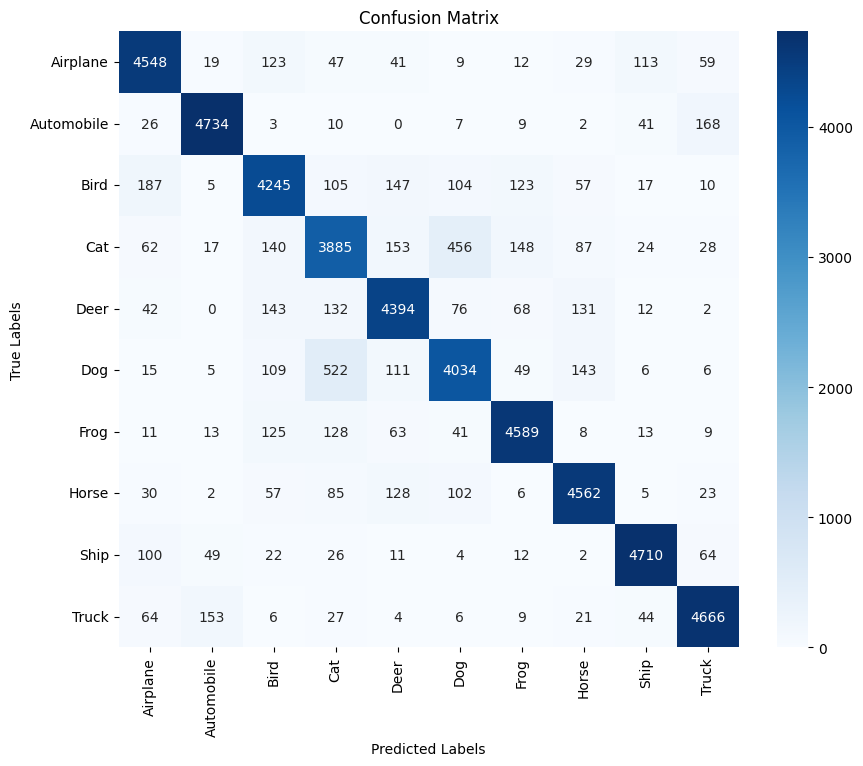

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_GlobalAvgPooling(nn.Module):
    def __init__(self):
        super(CNN_GlobalAvgPooling, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_avgpooling = CNN_BatchNorm()
model_avgpooling.to(device)

model_avgpooling_optimizer = torch.optim.RMSprop(
    model_avgpooling.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_avgpooling, model_avgpooling_optimizer, num_epochs)

Global Average Pooling didn't seem to improve accuracy and didn't have any effect on generalization either.

Test Loss: 0.7025, Accuracy: 79.61%
Precision: 0.8089, Recall: 0.7961, F1 Score: 0.7982


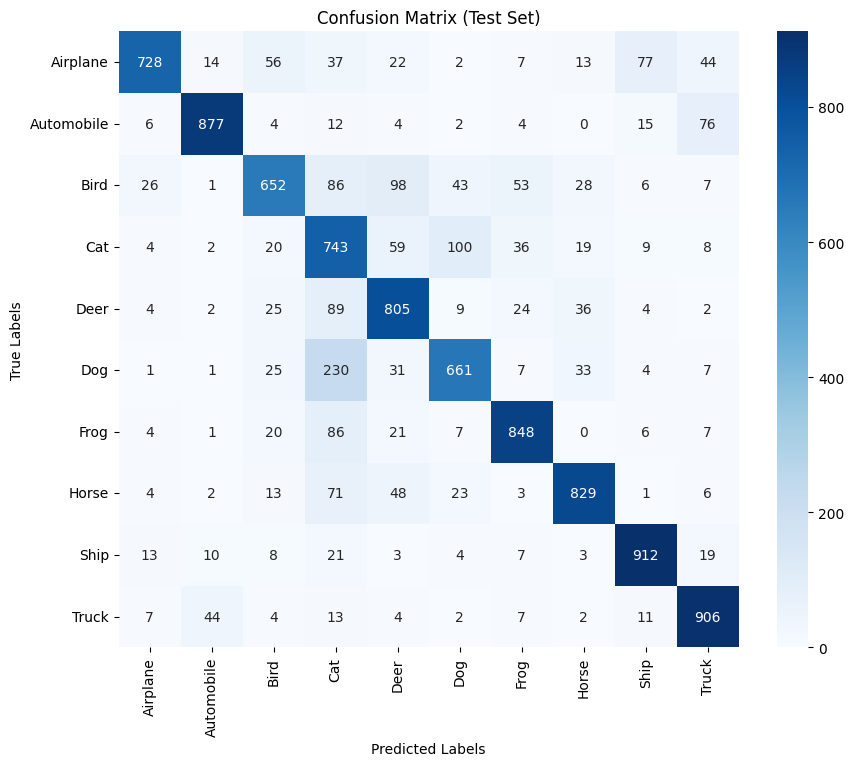

In [45]:
model_optimized_4.eval()
running_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(1)
        outputs = model_optimized_4(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {running_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_predictions, labels=range(10))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.show()